In [ ]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
import matplotlib.pyplot as plt

# path dataset
dataset_path = '/content/drive/MyDrive/dataset_split/'

# Assuming subdirectories for training and validation are directly inside the dataset directory
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

# Set device for model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations with augmentation for training and validation sets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare data loaders
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model setup
model = timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(train_dataset.classes))
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Usage example
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/10, Train Loss: 1.5534, Train Accuracy: 0.4853
Validation Loss: 2.4223, Validation Accuracy: 0.3529
Epoch 2/10, Train Loss: 1.1210, Train Accuracy: 0.6352
Validation Loss: 4.1350, Validation Accuracy: 0.5441
Epoch 3/10, Train Loss: 1.2008, Train Accuracy: 0.6547
Validation Loss: 2.4565, Validation Accuracy: 0.4118
Epoch 4/10, Train Loss: 1.0937, Train Accuracy: 0.6515
Validation Loss: 1.6940, Validation Accuracy: 0.5441
Epoch 5/10, Train Loss: 0.8132, Train Accuracy: 0.7524
Validation Loss: 1.5728, Validation Accuracy: 0.5882
Epoch 6/10, Train Loss: 0.8778, Train Accuracy: 0.6971
Validation Loss: 1.3455, Validation Accuracy: 0.6324
Epoch 7/10, Train Loss: 0.8443, Train Accuracy: 0.7003
Validation Loss: 1.3447, Validation Accuracy: 0.6176
Epoch 8/10, Train Loss: 0.8241, Train Accuracy: 0.7231
Validation Loss: 4.1751, Validation Accuracy: 0.4265
Epoch 9/10, Train Loss: 0.6983, Train Accuracy: 0.7524
Validation Loss: 1.6734, Validation Accuracy: 0.4412
Epoch 10/10, Train Loss: 0.7

In [3]:
dataset_path = '/content/drive/MyDrive/dataset_split/'

# Assuming subdirectories for training and validation are directly inside the dataset directory
test_path = os.path.join(dataset_path, 'test')


# Prepare data loaders
test_dataset = datasets.ImageFolder(root=test_path, transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


def evaluate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


evaluate_model(model, criterion, test_loader)


Loss: 1.3987, Accuracy: 0.6571


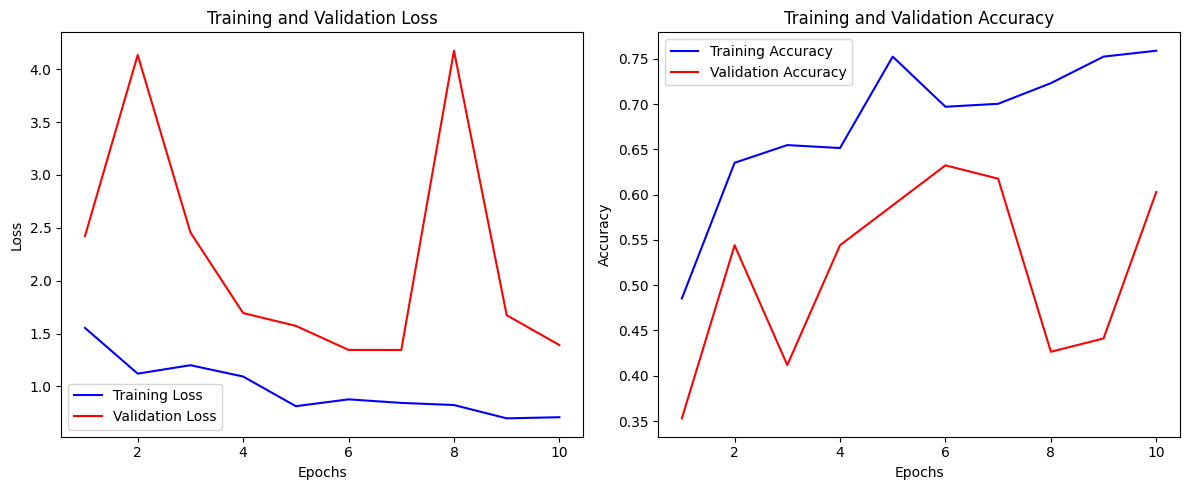

In [4]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)

    # Plotting training loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    if val_losses:
        plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    if val_accuracies:
        plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
